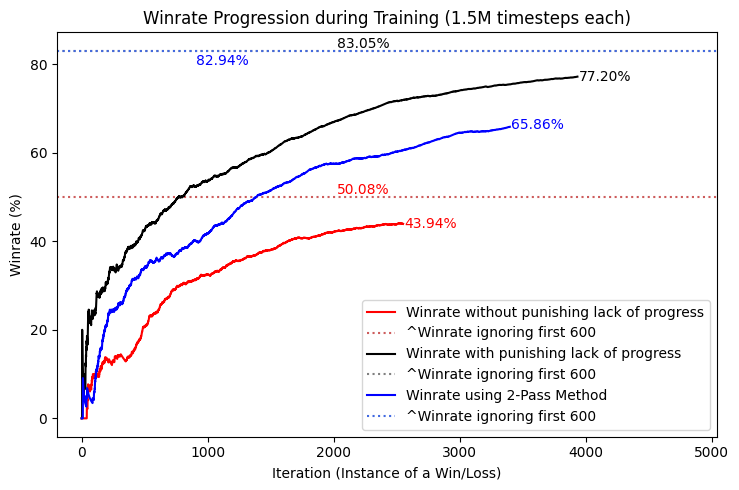

In [1]:
from os import read
from typing import final
import pandas as pd                     # type: ignore
import matplotlib.pyplot as plt         # type: ignore
import matplotlib.gridspec as gridspec  # type: ignore

def convert_to_time(timesteps):
    tps = 80  # estimated value for timesteps per second
    return round(timesteps / tps, 2)

def label_bars(ax, bars, color, append=""):
    for bar in bars:
        yval = bar.get_height()
        ax.text(bar.get_x() + bar.get_width() / 100.0, yval, f'{yval:.2f}{append}', va='bottom', color=color)

def process_winloss(winloss, ignore_phase):
    p1_iter_wins, p2_iter_wins, p3_iter_wins, total_wins = 0, 0, 0, 0
    p1_iter_losses, p2_iter_losses, p3_iter_losses, total_losses = 0, 0, 0, 0
    p1_iter_winlosses, p2_iter_winlosses, p3_iter_winlosses, total_iter_winlosses = [], [], [], []
    p1_iter_wins_ignore, p2_iter_wins_ignore, p3_iter_wins_ignore = 0, 0, 0
    p1_iter_losses_ignore, p2_iter_losses_ignore, p3_iter_losses_ignore = 0, 0, 0
    p1_iter_winlosses_ignore, p2_iter_winlosses_ignore, p3_iter_winlosses_ignore = [], [], []
    for index, row in winloss.iterrows():
        if row['WinLoss'] == 'win':
            if row['Pass'] == 1:
                p1_iter_wins += 1
                if index >= ignore_phase:
                    p1_iter_wins_ignore += 1
            elif row['Pass'] == 2:
                p2_iter_wins += 1
                if index >= ignore_phase + p1_iter_wins + p1_iter_losses:
                    p2_iter_wins_ignore += 1
            elif row['Pass'] == 3:
                p3_iter_wins += 1
                if index >= ignore_phase + p1_iter_wins + p1_iter_losses + p2_iter_wins + p2_iter_losses:
                    p3_iter_wins_ignore += 1
            total_wins += 1
        elif row['WinLoss'] == 'loss':
            if row['Pass'] == 1:
                p1_iter_losses += 1
                if index >= ignore_phase:
                    p1_iter_losses_ignore += 1
            elif row['Pass'] == 2:
                p2_iter_losses += 1
                if index >= ignore_phase + p1_iter_wins + p1_iter_losses:
                    p2_iter_losses_ignore += 1
            elif row['Pass'] == 3:
                p3_iter_losses += 1
                if index >= ignore_phase + p1_iter_wins + p1_iter_losses + p2_iter_wins + p2_iter_losses:
                    p3_iter_losses_ignore += 1
            total_losses += 1
        if (p1_iter_wins + p1_iter_losses) > 0 and row['Pass'] == 1:
            p1_iter_winlosses.append(p1_iter_wins / (p1_iter_wins + p1_iter_losses) * 100)
        if (p2_iter_wins + p2_iter_losses) > 0 and row['Pass'] == 2:
            p2_iter_winlosses.append(p2_iter_wins / (p2_iter_wins + p2_iter_losses) * 100)
        if (p3_iter_wins + p3_iter_losses) > 0 and row['Pass'] == 3:
            p3_iter_winlosses.append(p3_iter_wins / (p3_iter_wins + p3_iter_losses) * 100)
        if (p1_iter_wins_ignore + p1_iter_losses_ignore) > 0 and row['Pass'] == 1:
            p1_iter_winlosses_ignore.append(p1_iter_wins_ignore / (p1_iter_wins_ignore + p1_iter_losses_ignore) * 100)
        if (p2_iter_wins_ignore + p2_iter_losses_ignore) > 0 and row['Pass'] == 2:
            p2_iter_winlosses_ignore.append(p2_iter_wins_ignore / (p2_iter_wins_ignore + p2_iter_losses_ignore) * 100)
        if (p3_iter_wins_ignore + p3_iter_losses_ignore) > 0 and row['Pass'] == 3:
            p3_iter_winlosses_ignore.append(p3_iter_wins_ignore / (p3_iter_wins_ignore + p3_iter_losses_ignore) * 100)
        if (total_wins + total_losses) > 0:
            total_iter_winlosses.append(total_wins / (total_wins + total_losses) * 100)
    
    final_p1 = p1_iter_winlosses[-1] if p1_iter_winlosses else 0
    final_p2 = p2_iter_winlosses[-1] if p2_iter_winlosses else 0
    final_p3 = p3_iter_winlosses[-1] if p3_iter_winlosses else 0
    final_overall = total_iter_winlosses[-1] if total_iter_winlosses else 0
    final_p1_ignore = p1_iter_winlosses_ignore[-1] if p1_iter_winlosses_ignore else 0
    final_p2_ignore = p2_iter_winlosses_ignore[-1] if p2_iter_winlosses_ignore else 0
    final_p3_ignore = p3_iter_winlosses_ignore[-1] if p3_iter_winlosses_ignore else 0

    return (p1_iter_winlosses, p2_iter_winlosses, p3_iter_winlosses, total_iter_winlosses,
            final_p1, final_p2, final_p3, final_overall,
            final_p1_ignore, final_p2_ignore, final_p3_ignore)

def process_levelbeats(levelbeats_path, cutoff):
    levelbeats = pd.read_csv(levelbeats_path, header=None, names=['completion_timesteps', 'training_timesteps', 'time_in_seconds'])
    
    with open(levelbeats_path, 'r') as file:
        lines = file.readlines()
    try:
        split_index = lines.index('\n')
    except:
        split_index = len(levelbeats['completion_timesteps'])
    
    p_completion_t = levelbeats['completion_timesteps']
    p_training_t = levelbeats['training_timesteps']
    average_pass = convert_to_time(p_completion_t[-cutoff:].mean())
    fastest_pass = levelbeats[:split_index].nsmallest(5, 'completion_timesteps')
    
    return p_completion_t, p_training_t, average_pass, fastest_pass

def main():
    cutoff = 100
    p_colors = {1: ("red", "indianred"), 3: ("black", "gray")}

    winloss_paths = {1: './logs/winloss pass1only.csv', 3: './logs/winloss pass3only.csv'}
    levelbeats_paths = {1: './logs/levelbeats pass1only.csv', 3: './logs/levelbeats pass3only.csv'}

    data = {}
    for p in [1, 3]:
        winloss = pd.read_csv(winloss_paths[p], header=None, names=['WinLoss', 'Pass'])
        (p1_iter_winlosses, p2_iter_winlosses, p3_iter_winlosses, total_iter_winlosses,
        final_p1, final_p2, final_p3, final_overall,
        final_p1_ignore, final_p2_ignore, final_p3_ignore) = process_winloss(winloss, IGNORE_PHASE)
        
        p_completion_t, p_training_t, average_pass, fastest_pass = process_levelbeats(levelbeats_paths[p], cutoff)
        
        data[p] = {
            "p1_iter_winlosses": p1_iter_winlosses,
            "p2_iter_winlosses": p2_iter_winlosses,
            "p3_iter_winlosses": p3_iter_winlosses,
            "total_iter_winlosses": total_iter_winlosses,
            "final_p1": final_p1,
            "final_p2": final_p2,
            "final_p3": final_p3,
            "final_overall": final_overall,
            "final_p1_ignore": final_p1_ignore,
            "final_p2_ignore": final_p2_ignore,
            "final_p3_ignore": final_p3_ignore,
            "p_completion_t": p_completion_t,
            "p_training_t": p_training_t,
            "average_pass": average_pass,
            "fastest_pass": fastest_pass
        }

    fig = plt.figure(figsize=(7.5, 5))
    gs = gridspec.GridSpec(1, 1, width_ratios=[1], height_ratios=[1])
    ax0 = plt.subplot(gs[0])
    ax0.set_title('Winrate Progression during Training (1.5M timesteps each)')
    ax0.set_xlabel('Iteration (Instance of a Win/Loss)')
    ax0.set_ylabel('Winrate (%)')

    for p in [1, 3]:
        color, color_average = p_colors[p]
        mid_index = len(data[3]["p3_iter_winlosses"]) // 2
        if p == 1:
            ax0.plot(data[p]["p1_iter_winlosses"], color=color, label='Winrate without punishing lack of progress')
            ax0.annotate(f'{data[p]["final_p1"]:.2f}%', xy=(len(data[p]["p1_iter_winlosses"]) - 1, data[p]["final_p1"] - 1), xytext=(1, 0), textcoords='offset points', color=color)
            ax0.axhline(data[p]["final_p1_ignore"], color=color_average, linestyle='dotted', label=f'^Winrate ignoring first {IGNORE_PHASE}')
            ax0.annotate(f'{data[p]["final_p1_ignore"]:.2f}%', xy=(mid_index, data[p]["final_p1_ignore"]), xytext=(5, 2), textcoords='offset points', color=color, fontsize=10)
        elif p == 3:
            ax0.plot(data[p]["p3_iter_winlosses"], color=color, label='Winrate with punishing lack of progress')
            ax0.annotate(f'{data[p]["final_p3"]:.2f}%', xy=(len(data[p]["p3_iter_winlosses"]) - 1, data[p]["final_p3"] - 1), xytext=(1, 0), textcoords='offset points', color=color)
            ax0.axhline(data[p]["final_p3_ignore"], color=color_average, linestyle='dotted', label=f'^Winrate ignoring first {IGNORE_PHASE}')
            ax0.annotate(f'{data[p]["final_p3_ignore"]:.2f}%', xy=(mid_index, data[p]["final_p3_ignore"]), xytext=(5, 2), textcoords='offset points', color=color, fontsize=10)
    for ax in [ax0]:
        x_left, x_right = ax.get_xlim()
        padding = (x_right - x_left) * 0.1  # 10% right padding
        ax.set_xlim(x_left, x_right + padding)
        ax.legend()


        # Read the file and extract the win/losses
    def read_winloss_data(path):
        return pd.read_csv(path, header=None, names=['WinLoss', 'Pass'])

    def calculate_iterative_winrate(winloss):
        iter_wins, iter_losses = {1: 0, 2: 0, 3: 0}, {1: 0, 2: 0, 3: 0}
        iter_wins_ignore, iter_losses_ignore = {1: 0, 2: 0, 3: 0}, {1: 0, 2: 0, 3: 0}
        iter_winlosses, iter_winlosses_ignore, total_winlosses, total_winlosses_ignore = {1: [], 2: [], 3: []}, {1: [], 2: [], 3: []}, [], []
        total_wins, total_losses, total_wins_ignore, total_losses_ignore = 0, 0, 0, 0
        
        for index, row in winloss.iterrows():
            pass_num = row['Pass']
            if row['WinLoss'] == 'win':
                iter_wins[pass_num] += 1
                if index >= IGNORE_PHASE + (iter_wins[pass_num - 1] if pass_num > 1 else 0) + (iter_losses[pass_num - 2] if pass_num > 2 else 0):
                    iter_wins_ignore[pass_num] += 1
                    total_wins_ignore += 1
                total_wins += 1
            elif row['WinLoss'] == 'loss':
                iter_losses[pass_num] += 1
                if index >= IGNORE_PHASE + (iter_wins[pass_num - 1] if pass_num > 1 else 0) + (iter_losses[pass_num - 1] if pass_num > 1 else 0) + (iter_wins[pass_num - 2] if pass_num > 2 else 0) + (iter_losses[pass_num - 2] if pass_num > 2 else 0):
                    iter_losses_ignore[pass_num] += 1
                    total_losses_ignore += 1
                total_losses += 1
            # Calculate winrate at this point and store it in the list
            if (iter_wins[pass_num] + iter_losses[pass_num]) > 0:
                iter_winlosses[pass_num].append(iter_wins[pass_num] / (iter_wins[pass_num] + iter_losses[pass_num]) * 100)
            if (iter_wins_ignore[pass_num] + iter_losses_ignore[pass_num]) > 0:
                iter_winlosses_ignore[pass_num].append(iter_wins_ignore[pass_num] / (iter_wins_ignore[pass_num] + iter_losses_ignore[pass_num]) * 100)
            if (total_wins + total_losses) > 0:
                total_winlosses.append(total_wins / (total_wins + total_losses) * 100)
            if (total_wins_ignore + total_losses_ignore) > 0:
                total_winlosses_ignore.append(total_wins_ignore / (total_wins_ignore + total_losses_ignore) * 100)
        return iter_winlosses, iter_winlosses_ignore, total_winlosses, total_winlosses_ignore

    def plot_winrates(iter_winlosses, iter_winlosses_ignore, total_winlosses, total_winlosses_ignore, ax):
        final_winrates = {k: (v[-1] if v else 0) for k, v in iter_winlosses.items()}
        final_ignore_winrates = {k: (v[-1] if v else 0) for k, v in iter_winlosses_ignore.items()}
        final_total_winrate = total_winlosses[-1] if total_winlosses else 0
        final_total_ignore_winrate = total_winlosses_ignore[-1] if total_winlosses_ignore else 0

        ax.plot(total_winlosses, color='blue', label='Winrate using 2-Pass Method')
        ax.annotate(f'{final_total_winrate:.2f}%', xy=(len(total_winlosses)-1, final_total_winrate-0.5), xytext=(1, 0), textcoords='offset points', color='blue', fontsize=10)
        ax.axhline(y=final_total_ignore_winrate, color='royalblue', linestyle='dotted', label=f'^Winrate ignoring first {IGNORE_PHASE}')
        ax.annotate(f'{final_total_ignore_winrate:.2f}%', xy=(len(total_winlosses)//4, final_total_ignore_winrate), xytext=(5, -10), textcoords='offset points', color='blue', fontsize=10)

        for ax in [ax0]:
            x_left, x_right = ax.get_xlim()
            padding = (x_right - x_left) * 0.1
            ax.set_xlim(x_left, x_right + padding)
            ax.legend()

    read_winloss_data = read_winloss_data(WINLOSS_PATH)
    iter_winlosses, iter_winlosses_ignore, total_winlosses, total_winlosses_ignore = calculate_iterative_winrate(read_winloss_data)
    plot_winrates(iter_winlosses, iter_winlosses_ignore, total_winlosses, total_winlosses_ignore, ax0)

    plt.tight_layout(rect=[0, 0, 1, 1])
    plt.show()

#Customization
COLORS = {
    "p1": "red", "p2": "blue", "p3": "black",
    "p1_avg": "indianred", "p2_avg": "royalblue", "p3_avg": "gray"
}
IGNORE_PHASE = 800      # Number of initial wins/losses to ignore for winrate calculation
CUTOFF = 100            # Number of last wins to consider for average completion time
LEVELBEATS_PATH = './logs/levelbeats copy 4.csv'
WINLOSS_PATH = './logs/winloss copy 2.csv'
if __name__ == '__main__':
    main()
